# Use Python function to recognize hand-written digits with `ibm-watsonx-ai`

Create and deploy a function that receives HTML canvas image data from a web app and then processes and sends that data to a model trained to recognize handwritten digits.  
See: <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fl-tf2-tutorial.html?context=wx&audience=wdp" target="_blank">MNIST function deployment tutorial</a>  

This notebook runs on Python 3.12.

## Learning goals

The learning goals of this notebook are:

-  AI function definition
-  Store AI function
-  Deployment creation

## Contents

This notebook contains the following parts:
1. [Setup](#setup)
2. [Get an ID for a model deployment](#step4)
3. [Get sample canvas data](#step5)
4. [Create a deployable function](#upload)
5. [Store and deploy the function](#deploy)
6. [Test the deployed function](#score)
7. [Clean up](#cleanup)
8. [Summary](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact your Cloud Pak for Data administrator and ask them for your account credentials

### Install dependencies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [1]:
%pip install -U wget | tail -n 1
%pip install -U matplotlib | tail -n 1
%pip install -U ibm-watsonx-ai | tail -n 1

#### Define credentials

Authenticate the watsonx.ai Runtime service on IBM Cloud Pak for Data. You need to provide the **admin's** `username` and the platform `url`.

In [2]:
username = "PASTE YOUR USERNAME HERE"
url = "PASTE THE PLATFORM URL HERE"

Use the **admin's** `api_key` to authenticate watsonx.ai Runtime services:

In [ ]:
import getpass
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=getpass.getpass("Enter your watsonx.ai API key and hit enter: "),
    url=url,
    instance_id="openshift",
    version="5.2",
)

Alternatively you can use the **admin's** `password`:

In [3]:
import getpass
from ibm_watsonx_ai import Credentials

if "credentials" not in locals() or not credentials.api_key:
    credentials = Credentials(
        username=username,
        password=getpass.getpass("Enter your watsonx.ai password and hit enter: "),
        url=url,
        instance_id="openshift",
        version="5.2",
    )

#### Create `APIClient` instance

In [4]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watsonx-ai-samples/blob/master/cpd5.2/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [5]:
space_id = "PASTE YOUR SPACE ID HERE"

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [6]:
client.set.default_space(space_id)

'SUCCESS'

## 2. <a id="step4"></a> Get an ID for a model deployment

The deployed function created in this notebook is designed to send payload data to a TensorFlow model created with MNIST.

In [7]:
import os, wget, json
import numpy as np
import matplotlib.pyplot as plt

### Option 1: Use your own, existing model deployment

If you already deployed a model while working through one of the following MNIST tutorials, you can use that model deployment:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fl-tf2-tutorial.html?context=wx&audience=wdp" target="_blank" rel="noopener noreferrer">Experiment builder MNIST tutorial</a>

Paste the model deployment ID in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/wmls/wmls-deploy-overview.html?context=wx&audience=wdp" target="_blank" rel="noopener noreferrer">Looking up an online deployment ID</a>


In [8]:
for x in client.deployments.get_details()["resources"]:
    if x["entity"]["name"] == "Scikit German Risk Deployment WML V4":
        deployment_id = x["metadata"]["id"]

In [9]:
model_deployment_id = ""

### Option 2: Download, store, and deploy a sample model
You can deployed a sample model and get its deployment ID by running the code in the following four cells.

#### Download a sample model to the notebook working directory

In [10]:
sample_saved_model_filename = "mnist-tf-hpo-saved-model.tar.gz"
url = f"https://github.com/IBM/watsonx-ai-samples/raw/master/cpd5.2/models/tensorflow/mnist/{sample_saved_model_filename}"
if not os.path.isfile(sample_saved_model_filename):
    wget.download(url)

#### Look up software specification for the MNIST model

In [11]:
software_spec_id = client.software_specifications.get_id_by_name("runtime-24.1-py3.11")

#### Store the sample model in your watsonx.ai Runtime

In [12]:
metadata = {
    client.repository.ModelMetaNames.NAME: "Saved MNIST model",
    client.repository.ModelMetaNames.TYPE: "tensorflow_2.14",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_id,
}

model_details = client.repository.store_model(
    model=sample_saved_model_filename, meta_props=metadata
)

model_details

{'metadata': {'name': 'Saved MNIST model',
  'space_id': '8a13841b-df99-4b4d-bf2a-161ad2e33980',
  'resource_key': '28eeee2a-c663-497e-a1da-2294c2a6c9aa',
  'id': '868067d0-048c-4e86-8dbe-05a4480fefbe',
  'created_at': '2025-05-13T13:52:06Z',
  'rov': {'member_roles': {'1000331001': {'user_iam_id': '1000331001',
     'roles': ['OWNER']}}},
  'owner': '1000331001'},
 'entity': {'software_spec': {'id': '45f12dfe-aa78-5b8d-9f38-0ee223c47309'},
  'type': 'tensorflow_2.14'}}

#### Get published model ID

In [13]:
published_model_id = client.repository.get_model_id(model_details)

#### Deploy the stored model

In [14]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "MNIST saved model deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
}

model_deployment_details = client.deployments.create(
    published_model_id, meta_props=metadata
)



######################################################################################

Synchronous deployment creation for id: '868067d0-048c-4e86-8dbe-05a4480fefbe' started

######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.......
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='8b405e3c-2ac0-4d12-84b0-6a5ecac472b3'
-----------------------------------------------------------------------------------------------




#### Get the ID of the model deployment just created

In [15]:
model_deployment_id = client.deployments.get_id(model_deployment_details)
model_deployment_id

'8b405e3c-2ac0-4d12-84b0-6a5ecac472b3'

## <a id="step5"></a> 3. Get sample canvas data

The deployed function created in this notebook is designed to accept RGBA image data from an HTML canvas object.

Run the following cells to download and view sample canvas data for testing the deployed function.

### 3.1 Download sample data file

Download the file containing the sample data

In [16]:
sample_canvas_data_filename = "mnist-html-canvas-image-data.json"
url = f"https://github.com/IBM/watsonx-ai-samples/raw/master/cpd5.2/data/mnist/{sample_canvas_data_filename}"
if not os.path.isfile(sample_canvas_data_filename):
    wget.download(url)

Load the sample data from the file into a variable

In [17]:
with open(sample_canvas_data_filename) as data_file:
    sample_canvas_data = json.load(data_file)

### 3.2 View sample data

View the raw contents of the sample data

In [18]:
print("Height (n): " + str(sample_canvas_data["height"]) + " pixels\n")
print(
    "Num image data entries: "
    + str(len(sample_canvas_data["data"]))
    + " - (n * n * 4) elements - RGBA values\n"
)
print(
    json.dumps(sample_canvas_data, indent=3)[:75]
    + "...\n"
    + json.dumps(sample_canvas_data, indent=3)[-50:]
)

Height (n): 187 pixels

Num image data entries: 139876 - (n * n * 4) elements - RGBA values

{
   "data": [
      0,
      0,
      0,
      0,
      0,
      0,
      ...
      0,
      0,
      0
   ],
   "height": 187
}


See what hand-drawn digit the sample data represents

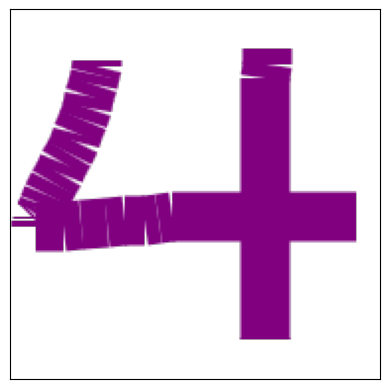

In [19]:
rgba_arr = np.asarray(sample_canvas_data["data"]).astype("uint8")
n = sample_canvas_data["height"]
plt.figure()
plt.imshow(rgba_arr.reshape(n, n, 4))
plt.xticks([])
plt.yticks([])
plt.show()

## <a id="upload"></a> 4. Create a deployable function

The basics of creating and deploying functions in watsonx.ai.

### 4.1 Define the function
1. Define a Python closure with an inner function named "score".
2. Use default parameters to save your Watson Machine Learning credentials and the model deployment ID with the deployed function.
3. Process the canvas data (reshape and normalize) and then send the processed data to the model deployment.
4. Process the results from the model deployment so the deployed function returns simpler results.
5. Implement error handling so the function will behave gracefully if there is an error.

In [20]:
parameters = {
    "credentials": credentials.to_dict(),
    "space_id": space_id,
    "model_deployment_id": model_deployment_id,
}


def my_deployable_function(params=parameters):
    import numpy as np
    from PIL import Image
    from ibm_watsonx_ai import APIClient

    def getRGBAArr(canvas_data):
        dimension = canvas_data["height"]
        rgba_data = canvas_data["data"]
        rgba_arr = np.asarray(rgba_data).astype("uint8")

        return rgba_arr.reshape(dimension, dimension, 4)

    def getNormAlphaList(img):
        alpha_arr = np.array(img.split()[-1])
        norm_alpha_arr = alpha_arr / 255
        norm_alpha_list = norm_alpha_arr.reshape(1, 784).tolist()

        return norm_alpha_list

    def score(function_payload):
        try:
            # Read the payload received by the function
            canvas_data = function_payload["input_data"][0]["values"][0]

            # Create an array object with the required shape
            rgba_arr = getRGBAArr(canvas_data)

            # Create an image object that can be resized
            img = Image.fromarray(rgba_arr, "RGBA")

            # Resize the image to 28 x 28 pixels
            sm_img = img.resize((28, 28), Image.LANCZOS)

            # Create a 1 x 784 array of values between 0 and 1
            alpha_list = getNormAlphaList(sm_img)

            # Create a payload to be sent to the model
            model_payload = {"input_data": [{"values": alpha_list}]}

            client = APIClient(
                credentials=params["credentials"], space_id=params["space_id"]
            )

            model_result = client.deployments.score(
                params["model_deployment_id"], model_payload
            )

            return model_result
        except Exception as exc:
            return {"predictions": [{"values": [repr(exc)]}]}

    return score

### 4.2 Test locally
You can test your function in the notebook before deploying the function.

In [21]:
func_result = my_deployable_function()(
    {"input_data": [{"values": [sample_canvas_data]}]}
)
print(func_result)

{'predictions': [{'id': 'classes', 'values': [4]}]}


## <a id="deploy"></a> 5. Store and deploy the function
Before you can deploy the function, you must store the function in your watsonx.ai Runtime.

#### Look up software specification for the deployable function

In [22]:
software_spec_id = client.software_specifications.get_id_by_name("runtime-24.1-py3.11")

#### Store the deployable function in your watsonx.ai Runtime

In [23]:
meta_data = {
    client.repository.FunctionMetaNames.NAME: "MNIST deployable function",
    client.repository.FunctionMetaNames.SOFTWARE_SPEC_UID: software_spec_id,
}

function_details = client.repository.store_function(
    meta_props=meta_data, function=my_deployable_function
)

#### Get published function ID

In [24]:
function_id = client.repository.get_function_id(function_details)

#### Deploy the stored function

In [25]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "MNIST function deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
}

function_deployment_details = client.deployments.create(
    function_id, meta_props=metadata
)



######################################################################################

Synchronous deployment creation for id: '47e6ca8b-1581-483f-9c61-fae87a4cceac' started

######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
......
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='cdb764ee-4a4b-4131-8baf-a8c26cba870d'
-----------------------------------------------------------------------------------------------




<a id="score"></a>
## 6. Test the deployed function

You can use the watsonx.ai Python client or REST API to send data to your function deployment for processing in exactly the same way you send data to model deployments for processing.

In [26]:
function_deployment_id = client.deployments.get_id(function_deployment_details)
function_deployment_endpoint_url = client.deployments.get_scoring_href(
    function_deployment_details
)
print(function_deployment_id)
print(function_deployment_endpoint_url)

In [27]:
payload = {"input_data": [{"values": [sample_canvas_data]}]}

### 6.1 watsonx.ai Python client

In [28]:
result = client.deployments.score(function_deployment_id, payload)
if "error" in result:
    print(result["error"])
else:
    print(result)

{'predictions': [{'id': 'classes', 'values': [4]}]}


## <a id="cleanup"></a> 7. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watsonx-ai-samples/blob/master/cpd5.2/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 8. Summary and next steps
In this notebook, you created a Python function that receives HTML canvas image data and then processes and sends that data to a model trained to recognize handwritten digits.

Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### <a id="authors"></a>Authors

**Sarah Packowski** is a member of the IBM Watson Studio Content Design team in Canada.

**Rafał Chrzanowski**, Software Engineer Intern at watsonx.ai.


<hr>
Copyright © 2018-2025 IBM. This notebook and its source code are released under the terms of the MIT License.